In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy

import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())
from statsmodels.stats.weightstats import _zstat_generic

import models
import dre
import rna
from calibrate import rectified_p_value
import vae
import designers
import editdistance
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

PATH = '/homefs/home/wongfanc/density-ratio-estimation'

True


2024-04-11 01:24:12.074548: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 01:24:12.074583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 01:24:12.075754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 01:24:12.082605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 01:24:13.787509: W tensorflow/comp

# PEX sensitivity to mutation rate, MDRE

In [2]:
# load training data (can train MDRE using both train and calibration)
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# load training data
data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

Loaded 5000 training points from /homefs/home/wongfanc/density-ratio-estimation/rna-models/traindata-nsd0.02-040324.npz.



In [3]:
# load calibration data
noise_sd = 0.02
p_mut = 4 / 50
fname = os.path.join(PATH, 'rna-results', 'calibration-pm{:.2f}-nsd{:.2f}-040524.npz'.format(p_mut, noise_sd))
d = np.load(fname)
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']

In [4]:
# load models to get predictions for calibration data
model_and_data_path = '/homefs/home/wongfanc/density-ratio-estimation/rna-models'
model_and_data_fname_no_ftype = 'nsd0.02-040324'
n_hidden = 100
n_filters = 32

# train ridge regression, load trained FF and CNN models
ridge = ridge = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
cnn.load(cnn_fname)

name2model = {
    'ridge': ridge,
    'ff': ff,
    'cnn': cnn
}

In [5]:
reload(designers)
model_name = 'cnn'
noise_sd = 0.02

landscape = rna.RNABinding(noise_sd=noise_sd)
model = name2model[model_name]
pex = designers.PEX(
    model,
    trainseq_n,
    ytrain_n,
    landscape.SEEDS[3],
)

In [6]:
# design and get labels
n_design = 50000
p_mutation = 2 / 50

designseq_n = pex.design_sequences(
    n_design,
    p_mutation,
)

t0 = time()
ydesign_n = landscape.get_fitness(calseqs_n)
print(int(time() - t0))

32


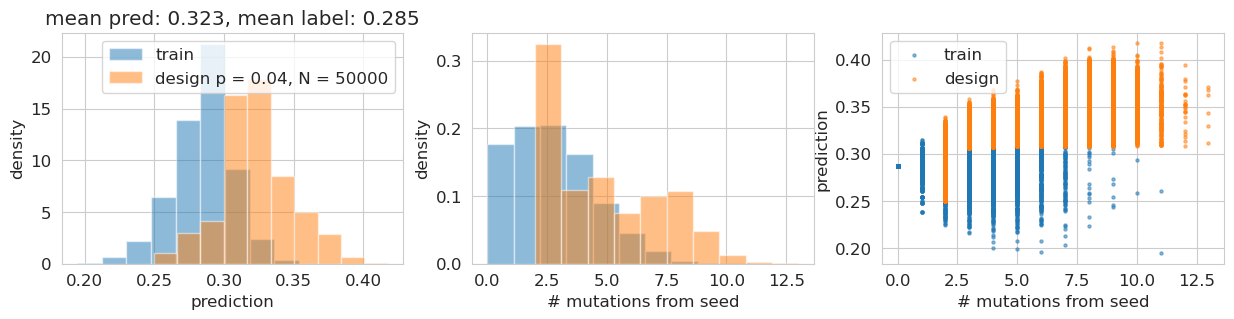

In [7]:
predtrain_n = model.predict(trainseq_n)
preddesign_n = model.predict(designseq_n)

disttrain_n = np.array([editdistance.eval(landscape.SEEDS[3], s) for s in trainseq_n])
distdesign_n = np.array([editdistance.eval(landscape.SEEDS[3], s) for s in designseq_n])

plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.hist(predtrain_n, alpha=0.5, label='train', density=True)
plt.hist(preddesign_n, alpha=0.5, label='design p = {:.2f}, N = {}'.format(p_mutation, n_design), density=True)
plt.legend()
plt.xlabel('prediction');
plt.ylabel('density');
plt.title('mean pred: {:.3f}, mean label: {:.3f}'.format(np.mean(preddesign_n), np.mean(ydesign_n)))

plt.subplot(132)
plt.hist(disttrain_n, alpha=0.5, density=True)
plt.hist(distdesign_n, alpha=0.5, density=True)
plt.xlabel('# mutations from seed');
plt.ylabel('density');

plt.subplot(133)
plt.scatter(disttrain_n, predtrain_n, alpha=0.5, label='train', s=5)
plt.scatter(distdesign_n, preddesign_n, alpha=0.5, label='design', s=5)
plt.legend()
plt.xlabel('# mutations from seed');
plt.ylabel('prediction');


In [8]:
# construct designname2data
designname2data = {}
preddesign_n = model.predict(designseq_n)
designname2data[f'pex-{model_name}'] = (designseq_n, ydesign_n, preddesign_n)    
designname2data['train'] = (calseqs_n + trainseq_n, np.hstack([ycal_n, ytrain_n]), None)
print(designname2data.keys())

dict_keys(['pex-cnn', 'train'])


In [9]:
# save
design_pkl_fname = os.path.join(PATH, 'rna-results', 'pex-{}-designs-041024.pkl'.format(model_name))
print(design_pkl_fname)
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(designname2data, f)


/homefs/home/wongfanc/density-ratio-estimation/rna-results/pex-cnn-designs-041024.pkl


In [5]:
# load (switch to torchenv for this cell onward)
model_name = 'cnn'
design_pkl_fname = os.path.join(PATH, 'rna-results', 'pex-{}-designs-041024.pkl'.format(model_name))
print(design_pkl_fname)
with open(design_pkl_fname, 'rb') as f:
    designname2data = pickle.load(f)

/homefs/home/wongfanc/density-ratio-estimation/rna-results/pex-cnn-designs-041024.pkl


One-hot-encoding all 2 categories of sequences...
  Done. (0 s)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 172.18it/s]


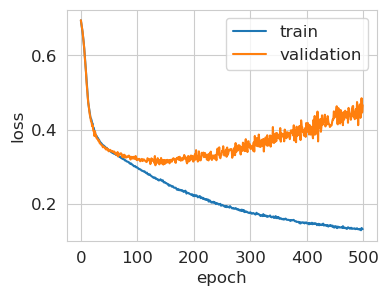

In [15]:
# fit MDRE
reload(dre)
n_hidden = 256
n_epoch = 500
lr = 1e-3

device = torch.device('cuda')

mdre = dre.MultinomialLogisticRegresssionDensityRatioEstimator(
    50,
    len(designname2data.keys()),
    n_hidden,
    device=device
)
loss_df = mdre.fit(
    designname2data,
    n_epoch,
    lr=lr
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df['train_loss'], label='train')
plt.plot(loss_df['val_loss'], label='validation')
plt.legend() 
plt.xlabel('epoch');
plt.ylabel('loss');
# plt.ylim([0, 1]);

In [16]:
# point estimates
alpha = 0.1
target_values = np.arange(0.3, 0.41, 0.01)
design_name = f'pex-{model_name}'
model = name2model[model_name]

# get DRs for each design distribution
designname2dr = mdre.get_dr(calseqs_n, self_normalize=True)
impaccept_t = []
ppaccept_t = []
    
designseq_n, ydesign_n, preddesign_n = designname2data[design_name] 
imputed_mean = np.mean(preddesign_n)
imputed_se = np.std(preddesign_n) / np.sqrt(preddesign_n.size)

caldr_n = designname2dr[design_name]
predcal_n = model.predict(calseqs_n)
rect_n = caldr_n * (ycal_n - predcal_n)
rectifier_mean = np.mean(rect_n)
rectifier_se = np.std(rect_n) / np.sqrt(rect_n.size)
pointest_3 = np.mean(ydesign_n), np.mean(preddesign_n) + rectifier_mean, np.mean(preddesign_n)

pp_se = np.maximum(np.sqrt(imputed_se ** 2 + rectifier_se ** 2), 1e-16)
ciwidth_2 = pp_se, imputed_se

print('{:.3f} {:.3f} {:.3f}\n'.format(
    np.mean(ydesign_n), np.mean(preddesign_n), np.mean(preddesign_n) + rectifier_mean
))

for target_val in target_values:
    
    # run imputation hypothesis test
    imp_pval = _zstat_generic(
        imputed_mean,
        0,
        imputed_se,
        alternative='larger',
        diff=target_val
    )[1]

    # run prediction-powered hypothesis test
    pp_pval = rectified_p_value(
        rectifier_mean,
        rectifier_se,
        imputed_mean,
        imputed_se,
        null=target_val,
        alternative='larger'
    )

    impaccept_t.append((imp_pval < alpha).astype(float))
    ppaccept_t.append((pp_pval < alpha).astype(float))

0.285 0.323 0.330



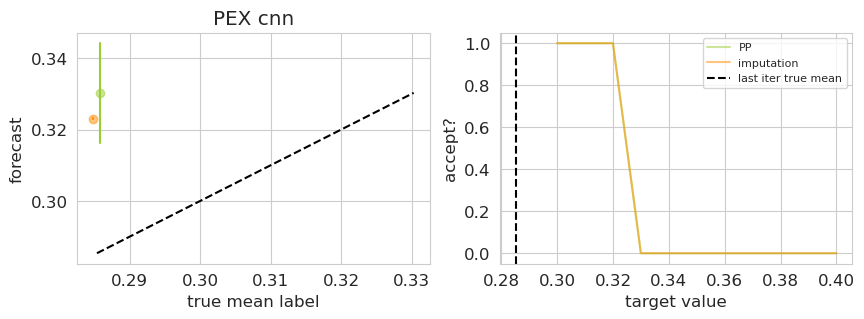

In [17]:
# run preliminary selection experiments and plot
title = f'PEX {model_name}'
truemean = np.mean(designname2data[design_name][1])
ppoff = 0.0005
impoff = -0.0005

xy_lim = [np.min(target_values), np.max(target_values)]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.scatter(pointest_3[0] + ppoff, pointest_3[1], label='PP', c='yellowgreen', alpha=0.5)
plt.scatter(pointest_3[0] + impoff, pointest_3[2], label='imputation', c='darkorange', alpha=0.5)
plt.plot(
    [pointest_3[0] + ppoff, pointest_3[0] + ppoff],
    [pointest_3[1] - 2 * ciwidth_2[0], pointest_3[1] + 2 * ciwidth_2[0]],
    c='yellowgreen'
)
plt.plot(
    [pointest_3[0] + impoff, pointest_3[0] + impoff],
    [pointest_3[2] - 2 * ciwidth_2[1], pointest_3[2] + 2 * ciwidth_2[1]],
    c='darkorange'
)
plt.plot([np.min(pointest_3), np.max(pointest_3)], [np.min(pointest_3), np.max(pointest_3)], '--k');
plt.xlabel('true mean label');
plt.ylabel('forecast');
plt.title(title);

plt.subplot(122)
plt.plot(target_values, ppaccept_t, label='PP', c='yellowgreen', alpha=0.5)
plt.plot(target_values, impaccept_t, label='imputation', c='darkorange', alpha=0.5)
plt.axvline(truemean, linestyle='--', color='k', label='last iter true mean')
plt.xlabel('target value');
plt.ylabel('accept?');
plt.legend(fontsize=8);